# MA755 College Scoreboard

Data Source:  https://collegescorecard.ed.gov/data
Group Members: Stacy Li, Michelle Zhao, Sylvia Gao

# Background

# 1. Data Import

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

Load the csv file for 2012-2013, which is the most recent dataset that contains earning information. NA value in the dataset is indicated by `NULL`. However, since we have no way to know the information in the cell labeled as `PrivacySuppressed`, we also include it in NA values.

In [2]:
data = pd.read_csv("MERGED2012_13_PP.csv", header = 0, na_values = ["NULL","PrivacySuppressed"])

In [3]:
data.head() #take a look

,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1133.0,NaN,NaN,1,0.4879,0.5121,1405.0,1574.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.290236,1485.0,NaN,NaN,1,0.4200,0.5800,3153.0,3481.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,1.0,NaN,NaN,1,0.4379,0.5621,264.0,336.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.307116,801.0,NaN,NaN,1,0.5425,0.4575,1208.0,1392.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1298.0,NaN,NaN,1,0.4046,0.5954,1951.0,1961.0


We would like to build a model to predict student's earning in the long term. So among all variables for earning, we select **median earning 10 years after entry** as our target variable. Given target variable we would like to predict, we manually selected 10 variables,  with one or two in each categories,that may be predictive.

In [3]:
#only select 10 variables that interest us
data_filter = data[['\ufeffUNITID',"OPEID","MD_FAMINC", "WDRAW_DEBT_MDN" , "PREDDEG", "STABBR",
"NPT4_PUB", "NPT4_PRIV", "PAR_ED_PCT_1STGEN", "DEP_STAT_PCT_IND", "PCTFLOAN", "MD_EARN_WNE_P10", "CONTROL"]]

Net price(estimated cost minus granted scholarship) is used to measure living cost for students in each school. But the net price information is recorded separatly in two columns in the original dataset, so we combine these two columns together.

In [4]:
#combine netprice for public school and private school together
data_filter['NPT4_COMBINE'] =  data_filter['NPT4_PRIV']  
data_filter.loc[data_filter['NPT4_COMBINE'].isnull(),'NPT4_COMBINE'] =  data_filter.loc[data_filter['NPT4_COMBINE'].isnull(),'NPT4_PUB']
data_filter.drop(["NPT4_PUB","NPT4_PRIV"],axis = 1, inplace = True)

In [5]:
data_filter.columns = ['CampusID', 'InstitutionID','MedianFamilyIncome','DebtNonCompleter',
                      'PredominantDegree','State','FirstGen','IndPerc','LoanPerc','MDEarning10','Control','NetPrice']

We also make the name of level of PredominantDegree and Control to make them more readable.

In [6]:
data_filter['PredominantDegree'] = data_filter['PredominantDegree'].map({0: 'Not classfied',1:'Certificate-degree',2:'Associate-degree',3:'Bachelor-degree',4:'Graduate-degree'})

In [7]:
data_filter['Control'] = data_filter['Control'].map({1:'Public',2:'Private nonprofit',3:'Private for-profit'})

Since our goal is to predict **median income 10 years after entry**, the next step would be to remove rows without this variable to ensure prediction accuracy. Rows lacking this variable can be saved for later prediction.

In [8]:
missing = data_filter.loc[data_filter["MDEarning10"].isnull(),:]
non_missing = data_filter.loc[~data_filter["MDEarning10"].isnull(),:]

In [9]:
#missing rate of each variable
non_missing.isnull().mean()*100

CampusID               0.000000
InstitutionID          0.000000
MedianFamilyIncome     0.462810
DebtNonCompleter      10.429752
PredominantDegree      0.000000
State                  0.000000
FirstGen               3.702479
IndPerc                2.082645
LoanPerc               7.140496
MDEarning10            0.000000
Control                0.000000
NetPrice              10.561983
dtype: float64

# 2.Data Exploration

## 2.1 Looking for patterns on the full data set

In [10]:
#Get quick discription of the data:
data_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793 entries, 0 to 7792
Data columns (total 12 columns):
CampusID              7793 non-null int64
InstitutionID         7793 non-null int64
MedianFamilyIncome    7505 non-null float64
DebtNonCompleter      6190 non-null float64
PredominantDegree     7793 non-null object
State                 7793 non-null object
FirstGen              6777 non-null float64
IndPerc               7093 non-null float64
LoanPerc              7041 non-null float64
MDEarning10           6050 non-null float64
Control               7793 non-null object
NetPrice              6660 non-null float64
dtypes: float64(7), int64(2), object(3)
memory usage: 730.7+ KB


In [11]:
data_filter.head()

,CampusID,InstitutionID,MedianFamilyIncome,DebtNonCompleter,PredominantDegree,State,FirstGen,IndPerc,LoanPerc,MDEarning10,Control,NetPrice
0,100654,100200,22681.34069,10064.0,Bachelor-degree,AL,0.369764,0.157669,0.7935,30300.0,Public,11726.0
1,100663,105200,35359.88195,8650.0,Bachelor-degree,AL,0.345912,0.330313,0.5529,39700.0,Public,15123.0
2,100690,2503400,18409.75222,5644.5,Bachelor-degree,AL,0.495726,0.907193,0.9679,40100.0,Private nonprofit,6927.0
3,100706,105500,33376.82879,8305.5,Bachelor-degree,AL,0.324873,0.378065,0.4787,45500.0,Public,11160.0
4,100724,100500,20444.53146,9500.0,Bachelor-degree,AL,0.403549,0.180830,0.8157,26600.0,Public,11029.0


Then we need to calculate the number of rows with at least 1, 2, or more missing values.

In [12]:
#calculate number of rows with missing values
sum(data_filter.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

3067

In [13]:
#calculate number of rows have at least 4 missing values
sum(data_filter.apply(lambda x: sum(x.isnull().values), axis = 1)>3)

608

In [14]:
#calculate number of rows have at least 6 missing values 
sum(data_filter.apply(lambda x: sum(x.isnull().values), axis = 1)>5)

292

In [15]:
#calculate number of rows have at least 8 missing values
sum(data_filter.apply(lambda x: sum(x.isnull().values), axis = 1)>7)

0

We can see there are totally 3067 rows have at least one missing value, 608 rows have at least 4 missing values, and 292 rows have at least 6 missing values. No row contains missing values more than 8. 
Later after we explore the data, we might think to delete the rows contain too many missing values. We also need to impute other missing values after we delete the rows with too many NA.

Then we need to explore the categorical variables:

From the head table of filtered data, there are totally 2 categorical variables: `Predominant Degree` and `Control`

In [16]:
data_filter["Control"].value_counts()

Private for-profit    3768
Public                2068
Private nonprofit     1957
Name: Control, dtype: int64

1 - Public ; 2 - Private Non-profit ; 3 - Private for Profit

In [17]:
data_filter["PredominantDegree"].value_counts()

Certificate-degree    3371
Bachelor-degree       2129
Associate-degree      1555
Not classfied          408
Graduate-degree        330
Name: PredominantDegree, dtype: int64

0 - not classified ; 1 - Predominantly certificate-degree granting;  2 - Predominantly associate's degree granting; 3 - Predominantly bachelor's-degree granting; 4 - Entirely graduate-degree granting

In [18]:
#Show summary describe of numerical variables
data_filter[['MedianFamilyIncome','DebtNonCompleter',
                     'FirstGen','IndPerc','LoanPerc','MDEarning10','NetPrice']].describe()

,MedianFamilyIncome,DebtNonCompleter,FirstGen,IndPerc,LoanPerc,MDEarning10,NetPrice
count,7505.000000,6190.000000,6777.000000,7093.000000,7041.000000,6050.000000,6660.000000
mean,25963.839578,5998.863005,0.480788,0.559266,0.536472,32930.661157,15263.235435
std,18824.305471,2415.623018,0.121651,0.233077,0.292615,14561.332554,7604.883823
min,0.000000,603.000000,0.068720,0.007263,0.000000,9500.000000,-19360.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,155606.577100,27625.000000,0.952494,0.985639,1.000000,233100.000000,87414.000000


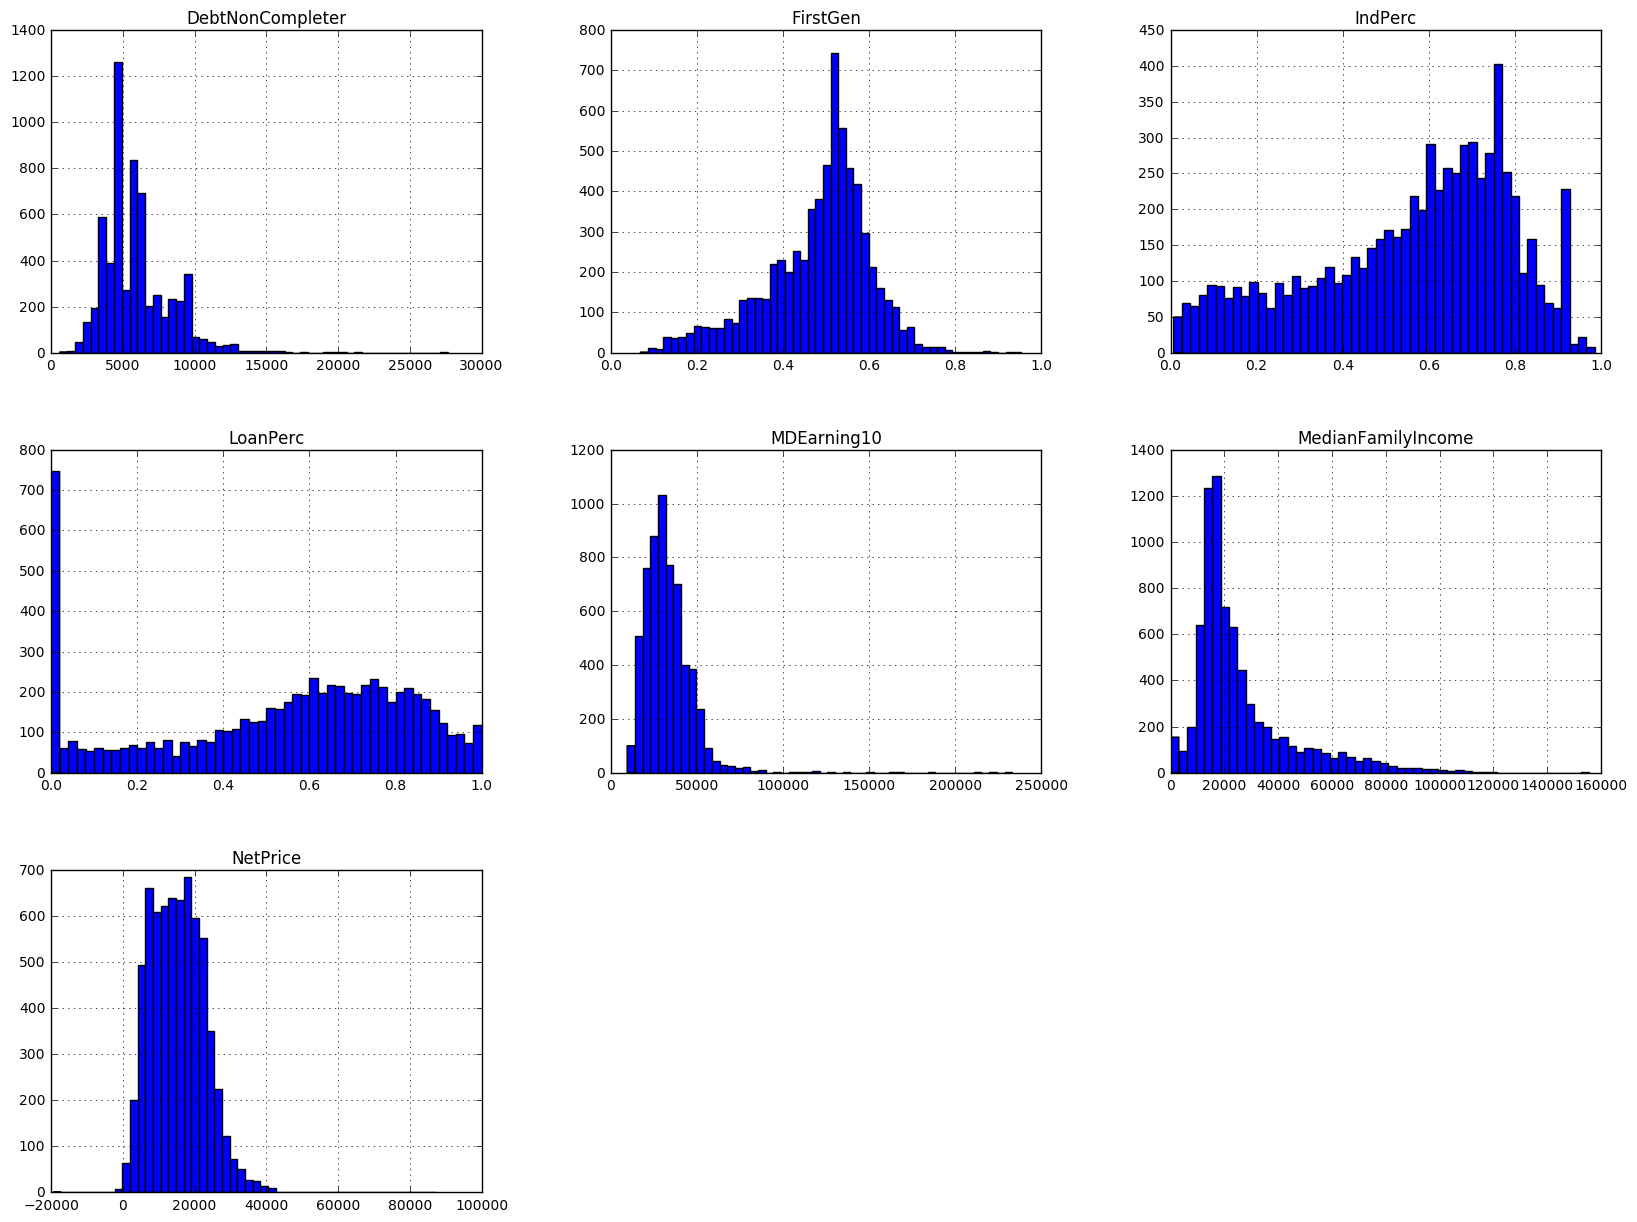

In [19]:
#set up matplotlib using jupyter backend so that we don't have to call the plot show every time
%matplotlib inline 
import matplotlib.pyplot as plt
#plot histogram with 50 bins within each plot.
data_filter[['MedianFamilyIncome','DebtNonCompleter',
                     'FirstGen','IndPerc','LoanPerc','MDEarning10','NetPrice']].hist(bins=50, figsize=(20,15))
plt.show()

From the histogram we can see: 

## 2.2 Split Data

In [20]:
#import hashlib package
import hashlib

#define test_set_check function to compute a hash of each instance's indentifier
def test_set_check(identifier, test_ratio, hash):
    #put the instance in the test set if the value is lower or equal to 51=20%*256
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

#Get the test and traning dataset based on the result of test_set_check() function
def split_train_test_by_id(data_filter, test_ratio, id_column, hash=hashlib.md5):
    ids = data_filter[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data_filter.loc[~in_test_set], data_filter.loc[in_test_set]

In [21]:
#split training dataset and test dataset by the newly created id column
np.random.seed(123)
train_set, test_set = split_train_test_by_id(non_missing, 0.2, "CampusID")

## 2.3 Looking for Correlations on train data set 

In [22]:
#Create a copy of trainin dataset:
copy_data =train_set.copy()


In [23]:
#Compute the standard correlation coefficient between every pair of attributes.
corr_matrix = copy_data.corr()

In [24]:
#Create correlations with the earning after 10 years of enrollment value and assort the result by descending
corr_matrix["MDEarning10"].sort_values(ascending=False)

MDEarning10           1.000000
MedianFamilyIncome    0.546578
DebtNonCompleter      0.469191
NetPrice              0.375803
LoanPerc              0.123027
InstitutionID         0.050708
CampusID              0.031169
IndPerc              -0.289751
FirstGen             -0.552881
Name: MDEarning10, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E3ADBB5160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E3AE3C63C8>]], dtype=object)

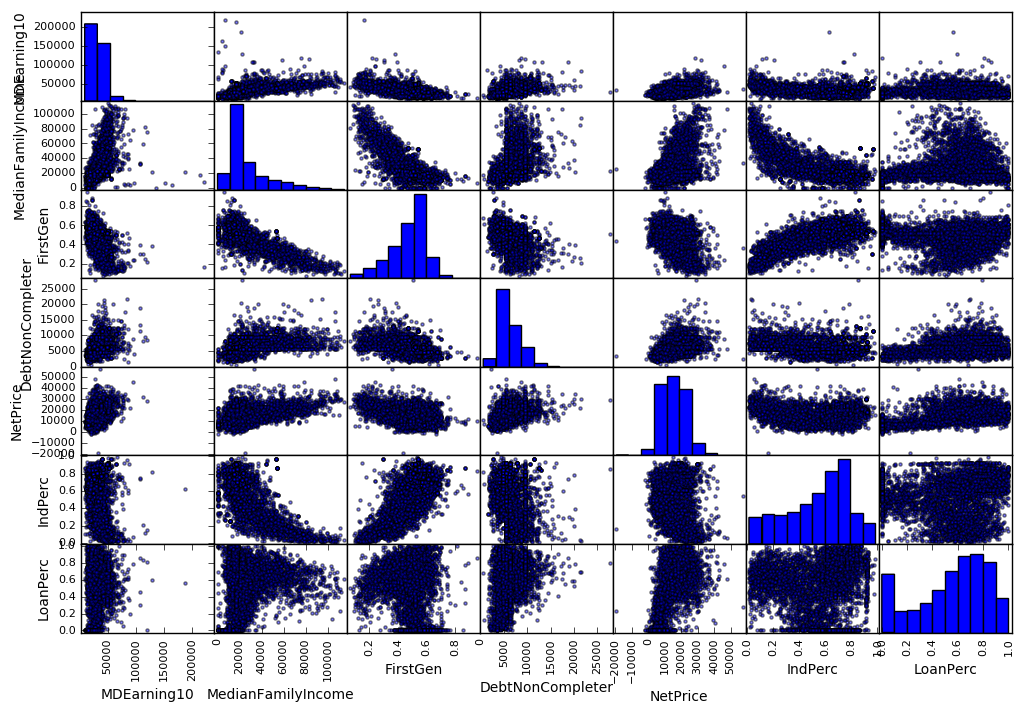

In [25]:
#import scatter_matrix function from Pandas package.
from pandas.tools.plotting import scatter_matrix

#only select promissing numerical variables and create scatter plot for every pairs 
attributes = ["MDEarning10", "MedianFamilyIncome", "FirstGen",
              "DebtNonCompleter","NetPrice","IndPerc","LoanPerc"]
#Create scatter matrix with size 12:8
scatter_matrix(copy_data[attributes], figsize=(12, 8))

# 3. Data Preparation

After doing some exploratory analysis, we have gained some insights into the dataset and identify several variables that may be useful for prediction such as median income and ocean proximity. Before proceeding to the modeling stage, we need to first prepare a clean dataset to feed into model, which requires us to do something about missing values and encode categorical variables to numerical variables.

First separate predictors and prediction label into two dataset, so that we can deal with the missing value in predictors without interrupting response variable.

In [26]:
college = train_set.drop("MDEarning10", axis=1) #drop this column
college_labels = train_set["MDEarning10"].copy()
print(college.shape)
print(college_labels.shape)

(4807, 11)
(4807,)


## 3.1 Data Cleaning

After getting two separate dataset for predictors and response variable. We can start off with data cleaning. Here, we decide to use median value of the column to replace missing values since the missing rate is not very high.

In [27]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median') #create a empty transformer with specified strategy

Drop columns not useful for prediction.

In [28]:
college.drop(["CampusID","InstitutionID"], axis = 1, inplace = True)

Drop categorical variables.

In [29]:
college_num = college.drop(['State', 'PredominantDegree','Control'], axis = 1)

Fit the transform to the dataset only containing numerical variables. Median value of each columns are estimated, which will later be used to perform transformation.

In [30]:
imputer.fit(college_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Use the parameter estimated to perform transformation.

In [31]:
X = imputer.transform(college_num)

The output is a numpy array, so we need to convert is back to pandas dataframe.

In [32]:
college_tr = pd.DataFrame(X, columns = college_num.columns) #numeric columns after imputation

## 3.2 Encode Categorical Variables

There are three categorical variables in the dataset: State, PredominantDegree, Control. They are all nominal variables, so we use `LabelBinarizer` transform to encode them into dummy variables. However, `LabelBinarized` can only accept one column as input, so I modify the transformer to allow multiple columns.

In [33]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

In [34]:
college_cat = college[['State', 'PredominantDegree','Control']]

We create a custom transformer `EncodeCategorical` to allow us to code multiple categorical variables into dummier at the same time.

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = columns
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelBinarizer().fit(data[column])
            for column in self.columns
        }
        self.classes_ = {
            column:encoder.classes_
            for column, encoder in self.encoders.items()
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = np.empty([len(data),0])
        for column, encoder in self.encoders.items():
             ay = encoder.transform(data[column])
             output = np.concatenate((output, ay), axis = 1)
        return output
    
    

In [36]:
len(college)

4807

In [37]:
encoder = EncodeCategorical(columns = ['State', 'PredominantDegree','Control'])
college_cat_tr = encoder.fit_transform(college)

The output is a numpy array with a size (4807, 66). All variables are dummy variables.

In [38]:
college_cat_tr.shape

(4807, 66)

## 3.3 Transformation Pipelines

 Then we can create a Pipeline to accommodate all the estimators and execute them in a sequence, which would make the modeling process more automated and easy to manage. It should be noted that all but the last estimators should be transformers which have fit_transform() method. When we call fit_transform() method, the output of each estimators is fed into next estimator, until the end of pipeline.

We create a estimator used to select variables of the same type, so that we can divide the processing of numerical variables and categorical variabls into two sub pipeline.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): #include BaseEstimator and TransformerMixin as base class
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):  #Don't have to estimate any parameter, so no action
        return self
    def transform(self, X):
        return X[self.attribute_names]

Now it's time to construct a full pipeline. The full pipeline consists of two parallel pipeline, one for categorical variables and one for numerical variables. At the beginning of each parallel pipeline, the `DataFrameSelector` is used to select only columns that we would like feed into the pipeline. At the end of pipeline, we use `FeatureUnion` function to combine two output together to form a clean dataset.

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = college_num.columns
cat_attribs = ['State', 'PredominantDegree','Control']

num_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy = 'median')),
        ('std_scaler', StandardScaler()), 
    ])

cat_pipeline = Pipeline([
        ('select', DataFrameSelector(cat_attribs)),
        ('label_binarizer', EncodeCategorical())
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])


Apply the full pipeline on the college data.

In [42]:
college_prepared = full_pipeline.fit_transform(college)
college_prepared.shape

(4807, 72)

The output of the pipelinw has a shape of (4807, 72)

# 4. Train and Select Models

In [43]:
#Prepare the testing data
X_test = test_set.drop(["CampusID","InstitutionID","MDEarning10"], axis=1)
Y_test = test_set["MDEarning10"].copy()
X_test_prepared = full_pipeline.transform(X_test)

## 4.1 Linear Regression Model

Let's first train a linear regression model. There are three steps:  
    1.Build a linear regression model on the train data set, and evalate model performance through RMSE  
    2.Apply Cross-Validation to validate the performance Linear Regression model  
    3.Evalate the linear regression model, by checking the RMSE on the test data set

### 4.1.1 Train a Linear Regression Model on  train data set

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Train the model
lin_reg = LinearRegression()
lin_reg.fit(college_prepared, college_labels)

#Calculate RMSE on on the train data set
from sklearn.metrics import mean_squared_error
lin_reg_pred = lin_reg.predict(college_prepared)
lin_mse = mean_squared_error(college_labels, lin_reg_pred)
lin_rmse = np.sqrt(lin_mse)
rsqure = r2_score(college_labels, lin_reg_pred) # familiar way to understand model performance


print("RMSE of the Linear Regression model on the train dataset is " +  str(round(lin_rmse,2)))  #10029.75
print("R-squre of the Linear Regression model on the train dataset is " +  str(round(rsqure,2)))  #0.52


print("Average Median earnings is " +  str(round(college_labels.mean(),0)))
print("Minimum Median earnings is " +  str(round(college_labels.min(),0))) 
print("Maximum Median earnings is " +  str(round(college_labels.max(),0))) 

RMSE of the Linear Regression model on the train dataset is 10029.67
R-squre of the Linear Regression model on the train dataset is 0.52
Average Median earnings is 32928.0
Minimum Median earnings is 9500.0
Maximum Median earnings is 233100.0


We build a linear regression model on the train data set. RMSE of this model is 10,029. In the train set, the median earnings range from \$9,500 to \$233,100, and the average is \$32,928. A prediction error of \$10,000 seems to be acceptable. But R-squre of this model tells us that the accuracy is only 52%. It is disappoiting.

### 4.1.2 Cross-Validation

In [48]:
np.random.seed(123)
from sklearn.model_selection import cross_val_score
lin_score = cross_val_score(lin_reg, college_prepared, college_labels,scoring='neg_mean_squared_error',cv=10)
lin_rmse_cv = np.sqrt(-lin_score).mean()
print("Average RMSE of the Linear Regression model with Cross-Validation is " +  str(round(lin_rmse_cv,2))) 


Average RMSE of the Linear Regression model with Cross-Validation is 32090227229.1


With cross-validation we can see that RMSE gets even larger. This means even the linear regression model is not satisfying. It still have the problem of overfit. Let's apply this model on the test data set to see how it performs.

### 4.1.3 Evaluation on test data set

In [49]:
lin_reg_pred_test = lin_reg.predict(X_test_prepared)
lin_mse_test = mean_squared_error(Y_test, lin_reg_pred_test)
lin_rmse_test = np.sqrt(lin_mse_test)
rsqure_test = r2_score(Y_test, lin_reg_pred_test) 
print("RMSE of the Linear Regression model on the test dataset is " +  str(round(lin_rmse_test,2)))  #9859.89
print("R-squre of the Linear Regression model on the test dataset is " +  str(round(rsqure_test,2)))  #0.56

RMSE of the Linear Regression model on the test dataset is 9859.58
R-squre of the Linear Regression model on the test dataset is 0.56


The linear regression model performs better on the test data set. But still, we can not be satisfied with this result. Therefore, we should consider other models.

## 4.2 Decision Tree Model

Let's try a more powerful model, decision tree model, on the train data set. The basic steps are similar to what we did in the Linear Regression model.

### 4.2.1 Build a Decision Tree Model

In [50]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(college_prepared, college_labels)
tree_pred = tree_reg.predict(college_prepared)
tree_mse = mean_squared_error(college_labels, tree_pred)
tree_rmse = np.sqrt(tree_mse)

print("RMSE of the Decision Tree model on the train dataset is " +  str(round(tree_rmse,2)))  #2150.5

print("Average Median earnings is " +  str(round(college_labels.mean(),0)))
print("Minimum Median earnings is " +  str(round(college_labels.min(),0))) 
print("Maximum Median earnings is " +  str(round(college_labels.max(),0))) 

RMSE of the Decision Tree model on the train dataset is 2150.5
Average Median earnings is 32928.0
Minimum Median earnings is 9500.0
Maximum Median earnings is 233100.0


The Decision Tree Model Performs much better than the Linear Regression model. The RMSE is only 2,151. However, it is very easy for the decision tree model to be overfitting. Therefore, before we apply this model on the test data set. We'll do validation first. Now, we use the Cross-Validation technique on the model fitting process.

### 4.2.2 Cross-Validation

In [51]:
np.random.seed(123)
tree_score = cross_val_score(tree_reg, college_prepared,college_labels,scoring='neg_mean_squared_error',cv=10)
tree_rmse_cv = np.sqrt(-tree_score).mean()
print("Average RMSE of the Linear Regression model with Cross-Validation is " +  str(round(tree_rmse_cv,2))) #11250

Average RMSE of the Linear Regression model with Cross-Validation is 11255.49


Now the decision tree model has larger prediction error. However, this is still much better than that of the linear regression model. Therefore, we believe the decision tree model is better. Let's apply this model on the test data set to see if it is better than the linear regression model.

### 4.2.3 Evaluation on test data set

In [52]:
tree_reg_pred_test = tree_reg.predict(X_test_prepared)
tree_mse_test = mean_squared_error(Y_test, tree_reg_pred_test)
tree_rmse_test = np.sqrt(tree_mse_test)
print("RMSE of the Decision Tree model on the test dataset is " +  str(round(tree_rmse_test,2)))  #10643.46

RMSE of the Decision Tree model on the test dataset is 11044.09


On the test data set, the decision tree model performs worse than the linear regression model. Before make the decision, let's try the last model Random Forest model.

## 4.3 Random Forest Model

Let's repeat the steps in the decision tree model

### 4.3.1 Build a Random Forest Model

In [53]:
np.random.seed(123)
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(college_prepared, college_labels)
rf_pred = rf_reg.predict(college_prepared)
rf_mse = mean_squared_error(college_labels, rf_pred)
rf_rmse = np.sqrt(rf_mse)

print("RMSE of the Random Forest model on the train dataset is " +  str(round(rf_rmse,2)))  #4418.74

RMSE of the Random Forest model on the train dataset is 4381.21


On the train data set, RMSE of the random forest model is better than the linear regression model, but worse than the decision tree model. Let's apply the Cross-Validation to see whether there is overfit in the random forest model.

### 4.3.2 Cross-Validation

In [54]:
np.random.seed(123)
rf_score = cross_val_score(rf_reg, college_prepared,college_labels,scoring='neg_mean_squared_error',cv=10)
rf_rmse_cv = np.sqrt(-rf_score).mean()
print("Average RMSE of the Linear Regression model with Cross-Validation is " +  str(round(rf_rmse_cv,2)))  #9148.45

Average RMSE of the Linear Regression model with Cross-Validation is 9024.07


This score is better than the previous two models. It seem that the random forest model is very promising. Let's check the performance on the test data set.

### 4.3.3 Evaluation on test data set

In [55]:
rf_reg_pred_test = rf_reg.predict(X_test_prepared)
rf_mse_test = mean_squared_error(Y_test, rf_reg_pred_test)
rf_rmse_test = np.sqrt(rf_mse_test)
print("RMSE of the Decision Tree model on the test dataset is " +  str(round(rf_rmse_test,2)))  #8486.69

RMSE of the Decision Tree model on the test dataset is 8289.64


On the test set the random forest model has the smallest RMSE, indicating the prediction error is only \$8,487. 

## 4.4 Model Selection

We've built three models and eveluate their performance on train data set and test data set. Cross-validation is also applied in the process. Now put all RMSE together

In [56]:
model_score = np.array([[lin_rmse,lin_rmse_cv,lin_rmse_test],[tree_rmse,tree_rmse_cv,tree_rmse_test],
                       [rf_rmse,rf_rmse_cv,rf_rmse_test]])
print(model_score)

[[  1.00296679e+04   3.20902272e+10   9.85957780e+03]
 [  2.15050401e+03   1.12554903e+04   1.10440894e+04]
 [  4.38121445e+03   9.02407148e+03   8.28964364e+03]]


From the output, we can see that random forest model perform the best on both train data set and test data set. In addition, average RMSE in the cross-validation process is relatively close to RMSE without validation. We can believe that the model is not overfitting. Therefore, we will use choose the random forest model as the best model.

# 5. Fine-tune the best model

## 5.1 Build a search grid

We've chosen random forest model as our final model. We can further fine-tune hyperparameteres of this model to make the model perform better.

In [57]:
from sklearn.model_selection import GridSearchCV
np.random.seed(123) 
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20,]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20, 25,30,35,40]},
  ] # define which hyperparameters and corresponding values we want to experiment

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error') # search the best combination using 5-fold cross-validation

grid_search.fit(college_prepared, college_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [5, 10, 15, 20], 'n_estimators': [3, 10, 30]}, {'n_estimators': [3, 10, 30], 'max_features': [5, 10, 15, 20, 25, 30, 35, 40], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

## 5.2 Best hyperparameters

In [58]:
grid_search.best_params_

{'max_features': 5, 'n_estimators': 30}

In [66]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
    

12791.0184152 {'n_estimators': 3, 'max_features': 5}
9982.08848524 {'n_estimators': 10, 'max_features': 5}
9127.61707238 {'n_estimators': 30, 'max_features': 5}
11012.0425054 {'n_estimators': 3, 'max_features': 10}
10306.0720554 {'n_estimators': 10, 'max_features': 10}
9578.18372399 {'n_estimators': 30, 'max_features': 10}
12000.0647934 {'n_estimators': 3, 'max_features': 15}
9867.42278838 {'n_estimators': 10, 'max_features': 15}
9559.32498142 {'n_estimators': 30, 'max_features': 15}
10638.5893861 {'n_estimators': 3, 'max_features': 20}
10182.8859256 {'n_estimators': 10, 'max_features': 20}
9525.96150212 {'n_estimators': 30, 'max_features': 20}
11698.7451534 {'max_features': 5, 'n_estimators': 3, 'bootstrap': False}
9920.62341596 {'max_features': 5, 'n_estimators': 10, 'bootstrap': False}
9477.36108698 {'max_features': 5, 'n_estimators': 30, 'bootstrap': False}
11140.152279 {'max_features': 10, 'n_estimators': 3, 'bootstrap': False}
9732.73611563 {'max_features': 10, 'n_estimators': 10

According to the results, the random forest model will perform the best if we use **10** features to build **30** subtrees. But the question is which 10 features should we use? We can take a look at the feature importances in the random forest model

## 5.3 Feature Importances

In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  1.76057317e-01,   8.63950737e-02,   1.05912077e-01,
         9.66213018e-02,   6.80926966e-02,   8.20820389e-02,
         3.21873480e-02,   3.11463376e-02,   1.35023725e-02,
         1.07389185e-04,   5.71289287e-04,   1.07492870e-03,
         1.36490860e-05,   5.25247565e-03,   7.43677954e-03,
         1.02052437e-03,   2.38249472e-03,   8.50978868e-04,
         1.77353788e-04,   2.63309571e-03,   3.31568624e-05,
         1.18520680e-03,   4.24890505e-05,   2.99641251e-04,
         9.85708446e-04,   6.04294944e-04,   3.43911849e-03,
         1.34379846e-03,   8.82296604e-04,   2.63659685e-03,
         4.78371553e-03,   7.79031386e-03,   2.19413134e-03,
         8.21309011e-04,   1.84889884e-03,   2.02829326e-03,
         3.24931474e-03,   2.13793791e-06,   6.42216636e-04,
         4.21480036e-04,   2.06638298e-03,   4.65395559e-04,
         5.37865490e-04,   2.35653259e-03,   4.13853599e-03,
         3.18577799e-04,   2.05318982e-04,   1.34980811e-02,
         2.14799429e-03,

We need to display these importance scores to their corresponding attributes name to have a full understanding. Let's add attributes names.

In [72]:
classes = list(encoder.classes_.values())

In [73]:
column_name = np.concatenate((np.array(college_num.columns),classes[0], classes[1], classes[2]),axis=0)

In [74]:
pd.DataFrame({'Column':column_name,'Importance':feature_importances}).sort(['Importance'], ascending = False)

,Column,Importance
0,MedianFamilyIncome,0.176057
2,FirstGen,0.105912
3,IndPerc,0.096621
1,DebtNonCompleter,0.086395
5,NetPrice,0.082082
4,LoanPerc,0.068093
70,Graduate-degree,0.062017
68,Bachelor-degree,0.057469
69,Certificate-degree,0.039025
6,Private for-profit,0.032187


Now we can see that, numeric features are more important than categorical features. Therefore, a university's students earning after 10 years is highly correlated with its median family Income, the percentage of first-generation students, the percentage of students who are financially independent, the median debt for students who have not completed, average net price for Title IV institutions, the percent of all federal undergraduate students receiving a federal student loan. 

Median family income plays the key role. It is not to understand. With family monetary support, it would be easier for students to focus on developing their interests and skills. They are also more likely to earn other degrees or certificates. In this way, these students could be more competitive in the job market.

